# HW10 Assignment II - Spatial Data Analysis (Winter / Summer)

This notebook presents an exploratory spatial data analysis of CitiBike data using pysal and geopandas. The notebook is based on Assignment I and takes the analysis one step further by segmenting the data into winter and summer months. 

In [2]:
# Imports to work with with statistical analysis, maps, etc.

%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import json
import requests
import urllib2
import statsmodels.api as sm
import shapely
import seaborn as sns

# Using the last development version of geopandas at this time
# pip install git+git://github.com/geopandas/geopandas.git
from geopandas import GeoDataFrame

import pysal as ps

from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)
pl.rcParams['font.size']=12

/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Part I - Working with Shape Files

In [5]:
# Loading a shape file for the census trac on a geodataframe

shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [6]:
# Coordinate systems, projections, and transformations
# Using the fiona package rom_epsg method to set the geodataframe crs
# and calculate the total land are of NY using the to_crs method

ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

ct_shape.head()

total NYC land area: 302.3 (mi^2)


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


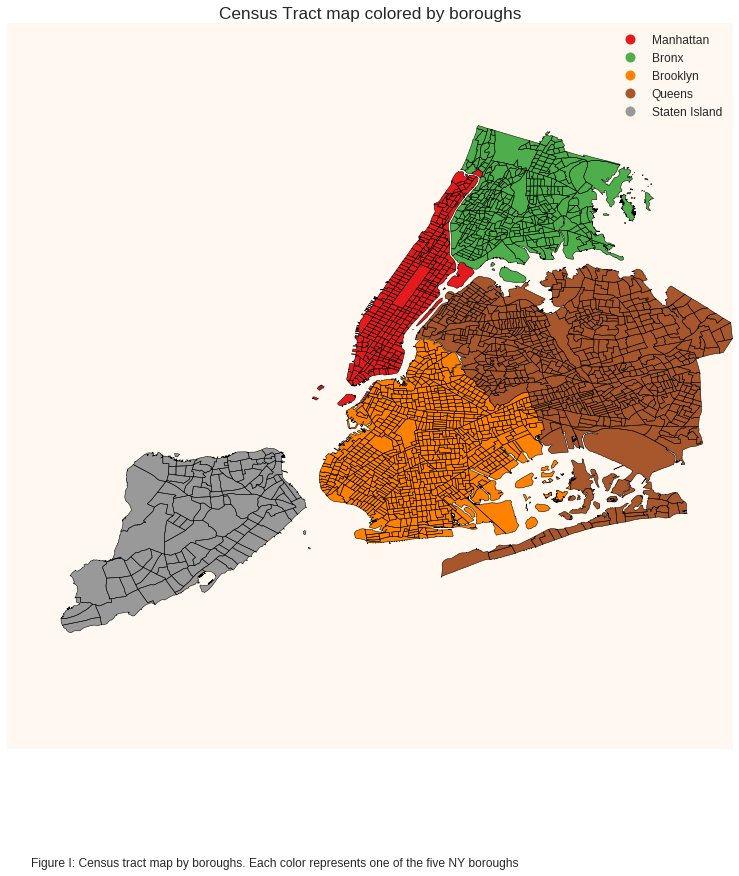

In [7]:
# Using the geopandas plotting capabilities to visualize the data

f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax, legend=True, )
legend = ax.get_legend()
legend.get_texts()[0].set_text('Manhattan')
legend.get_texts()[1].set_text('Bronx')
legend.get_texts()[2].set_text('Brooklyn')
legend.get_texts()[3].set_text('Queens')
legend.get_texts()[4].set_text('Staten Island')

pl.title("Census Tract map colored by boroughs")
pl.figtext(0.15,0,"Figure I: Census tract map by boroughs. Each color represents one of the five NY boroughs ")

### Map NYC Population density

In [8]:
# load the NYC census data for 2010
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [9]:
# Join the GeoDataFrame with the dataframe containing census data
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

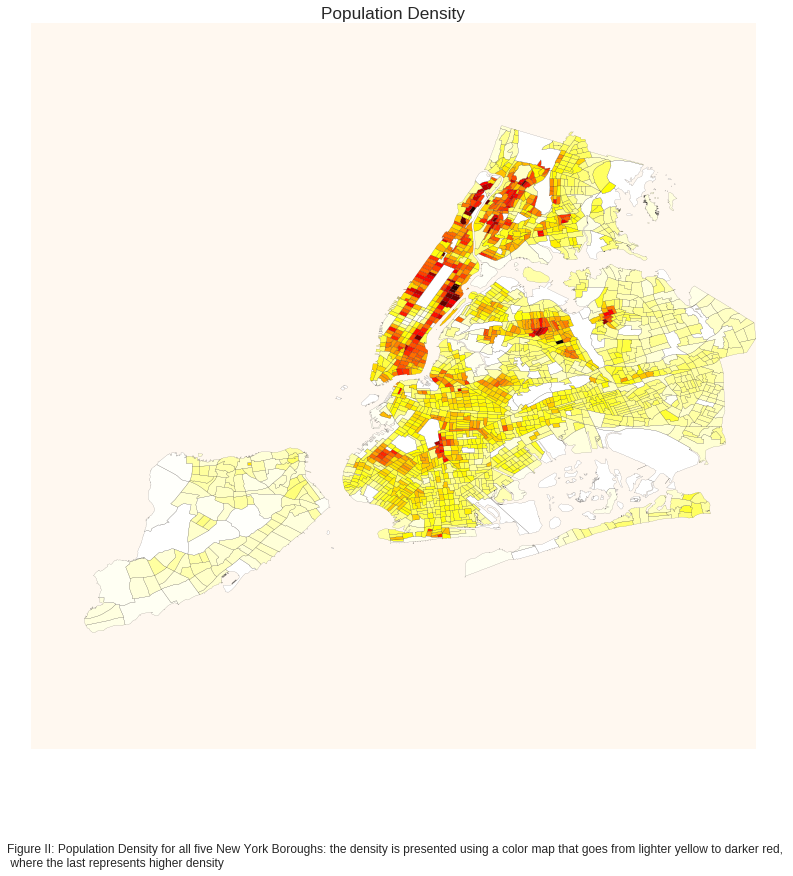

In [66]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Population Density")
pl.figtext(0.1,0,"Figure II: Population Density for all five New York Boroughs: the density is presented using "
          "a color map that goes from lighter yellow to darker red, \n where the last represents higher density")

## Explore CitiBike data

### Load CitiBike data

In [14]:
# Create a dataframw with the monthly rides by citibike station
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

# Create separate dataframes for summer and winter months.
# We will consider summer months 7, 8 and 9 (official US summer start is June20 / 21, end is September 22)
# We will consider winter months as 1, 2 and 3

df_bike_summer = df_bike_monthly[(df_bike_monthly.index.month > 6) &
                                (df_bike_monthly.index.month <= 9)]

df_bike_winter = df_bike_monthly[(df_bike_monthly.index.month > 0) &
                                (df_bike_monthly.index.month <= 3)]

### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


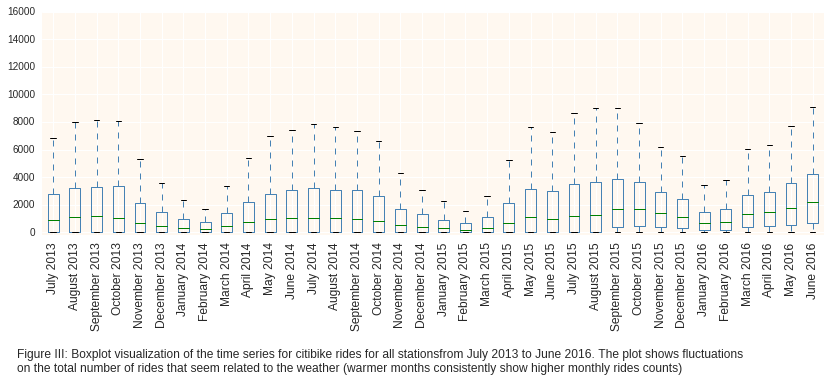

In [15]:
# Create a copy of the df for the viz purposes and plot using boxplot

pl.rcParams['font.size']=12
f, ax = pl.subplots(figsize=(14,4))

df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

pl.figtext(0.1,-.35,"Figure III: Boxplot visualization of the time series for citibike rides for all stations" 
          "from July 2013 to June 2016. The plot shows fluctuations \n" 
           "on the total number of rides that seem related to the weather (warmer months consistently show higher " 
          "monthly rides counts)")

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


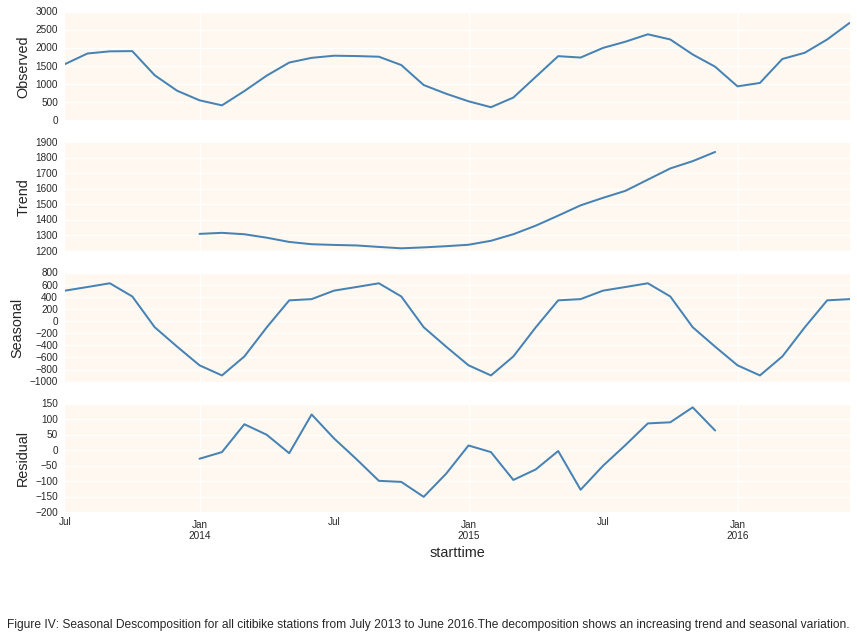

In [16]:
# reate a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

# Seasonal Decomposition using statsmodels api
# http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas
res = sm.tsa.seasonal_decompose(df_new.dropna())
pl.rcParams['figure.figsize']=(12,8)
resplot = res.plot()
pl.figtext(0.01,-.1,"Figure IV: Seasonal Descomposition for all citibike stations from July 2013 to June 2016."
           "The decomposition shows an increasing trend and seasonal variation.")

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [67]:
# Create Dataframe with station IDs
station_id=DataFrame.from_csv('Data/Station_id.csv')

#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [68]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)

# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [69]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [70]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [71]:
### Create average monthly, winter and summer rides columns
### from the three datasets and add it to the station id which has the geometry

station_id['MonthlyAve']=df_bike_monthly.mean()
station_id['WinterAve'] = df_bike_winter.mean()
station_id['SummerAve'] = df_bike_summer.mean()

In [72]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,WinterAve,SummerAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1925.222222,993.222222,2548.888889
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,2856.222222,1184.111111,3921.111111
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,7597.916667,4139.666667,9958.222222
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,2831.916667,1488.222222,3698.555556
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,5112.333333,2368.888889,6912.777778


### Add the monthly average rides to the CT shapefile 

In [73]:
temp = station_id[['MonthlyAve', 'WinterAve', 'SummerAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


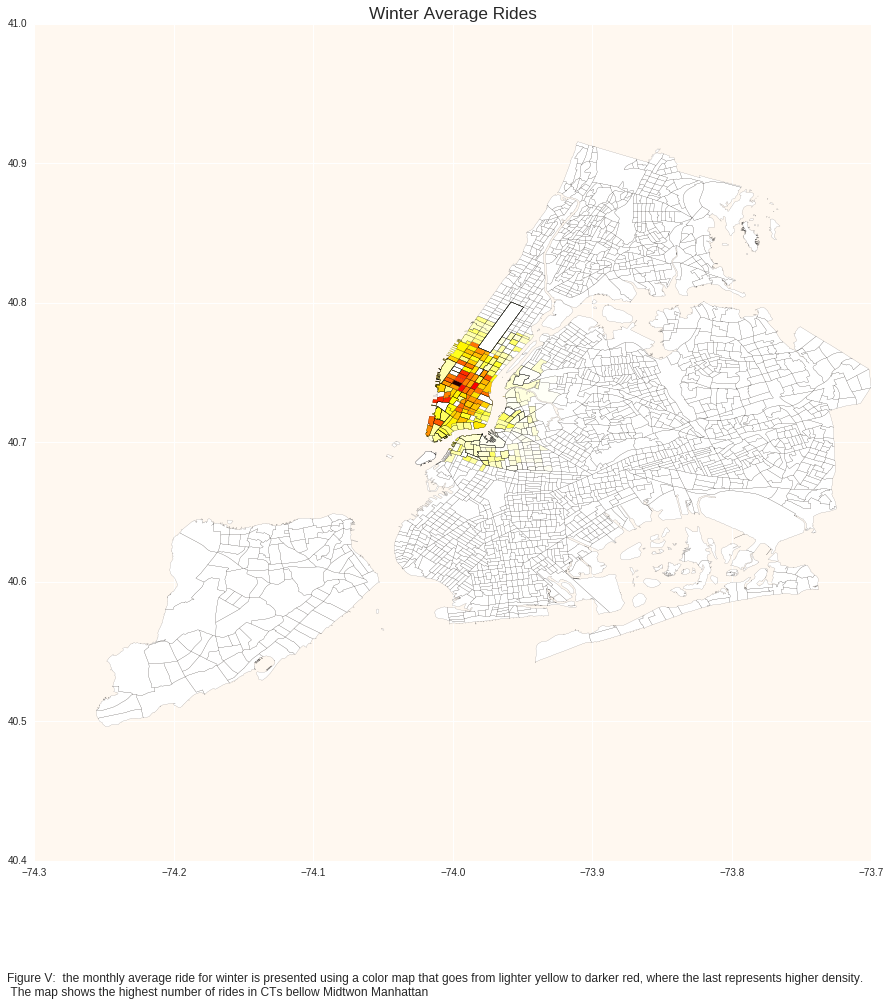

In [31]:
f, ax = pl.subplots(figsize=(15,15))
ct_shape_MonthlyAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Winter Average Rides")
pl.figtext(0.1,0,"Figure V:  the monthly average ride for winter is presented using "
          "a color map that goes from lighter yellow to darker red, where the last represents higher density. \n"
           " The map shows the highest number of rides in CTs bellow Midtwon Manhattan")

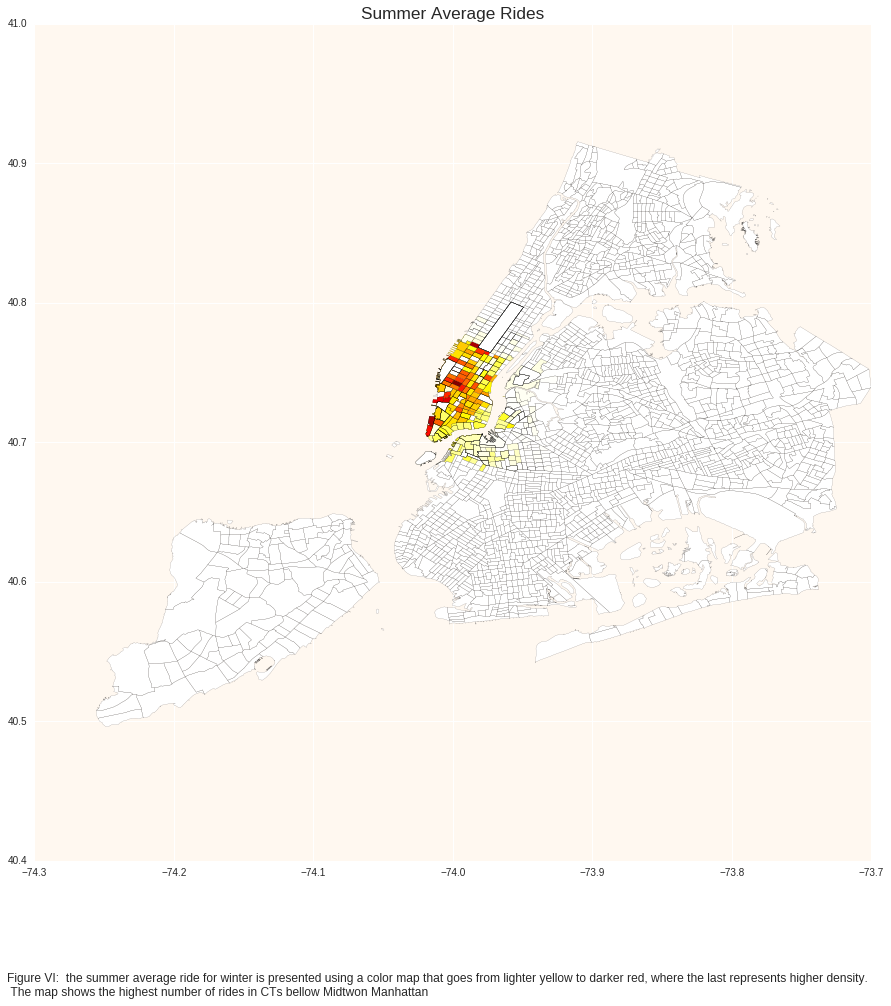

In [33]:
f, ax = pl.subplots(figsize=(15,15))
ct_shape_MonthlyAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Summer Average Rides")
pl.figtext(0.1,0,"Figure VI:  the summer average ride for winter is presented using "
          "a color map that goes from lighter yellow to darker red, where the last represents higher density. \n"
           " The map shows the highest number of rides in CTs bellow Midtwon Manhattan")

### Removing the CTs that are out of zoom boundries

In [74]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [75]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

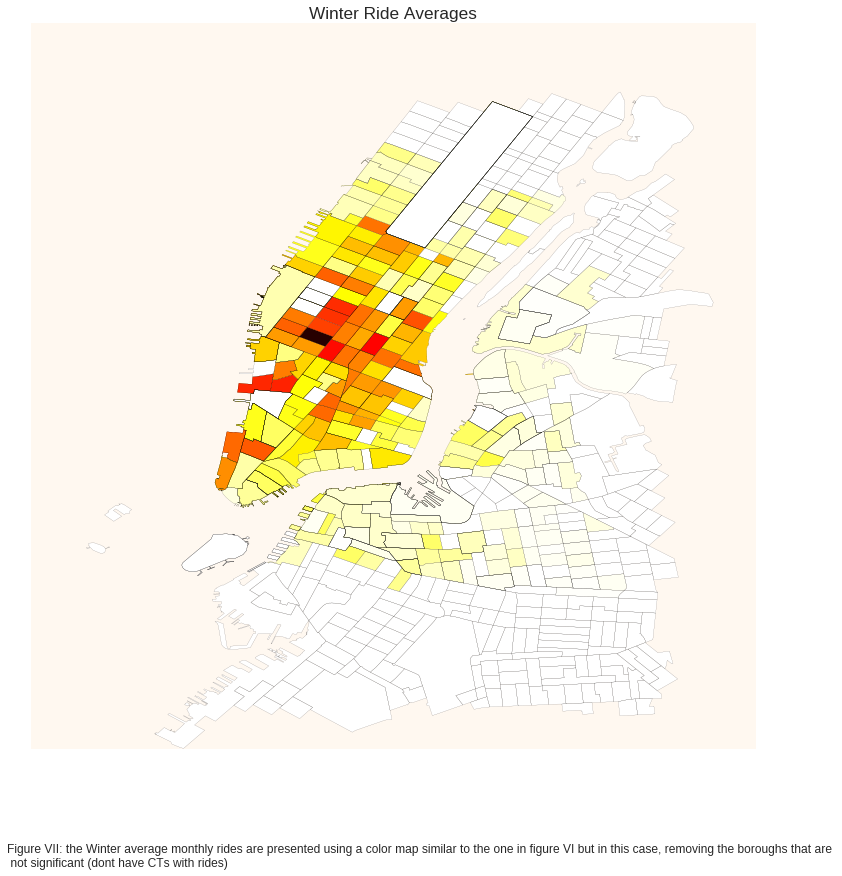

In [82]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Winter Ride Averages")

pl.figtext(0.1,0,"Figure VII: the Winter average monthly rides are presented using a color"
           " map similar to the one in figure VI but in this case, removing the boroughs that"
           " are \n not significant (dont have CTs with rides)")

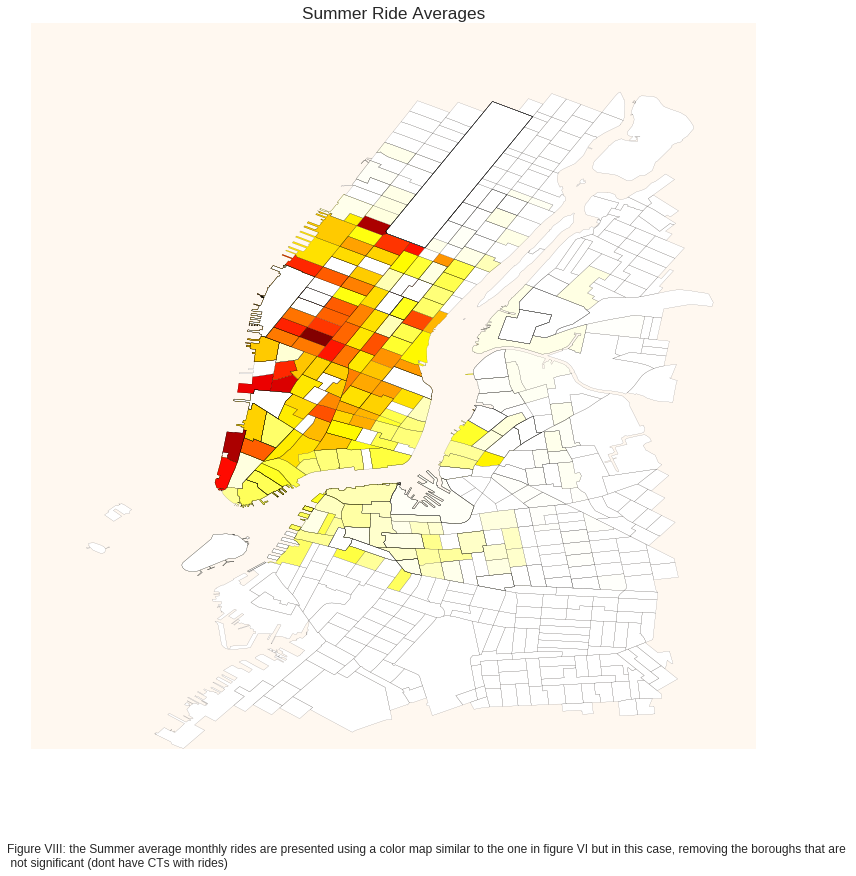

In [81]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Summer Ride Averages")

pl.figtext(0.1,0,"Figure VIII: the Summer average monthly rides are presented using a color "
           "map similar to the one in figure VI but in this case, removing the boroughs that are"
           " \n not significant (dont have CTs with rides)")

### Export Shapefile CTs in the CitiBike Zone

In [40]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Part II - Exploratory Geospatial Analysis

### Spatial Weights

The first analysis that we will perform is the spatial weights. "The spatial weights matrix expresses the potential for interaction between observations at each pair i,j of locations"

https://pysal.readthedocs.io/en/latest/users/tutorials/weights.html


We will specifically use Queen Weights (based on contiguity and distance criteria) using the pysal queen_from_shapefile function

http://pysal.readthedocs.io/en/v1.11.0/library/weights/user.html

In [83]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [84]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [85]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [86]:
Wmatrix, ids = qW_CT.full()

In [87]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [88]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  

"observations are spatially dependent"

The spatial lag presents a meassure of how neighboring observations affect one another

http://projects.iq.harvard.edu/sss_blog/spatial_lag_1

Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [95]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

MonthlyRideWinter = ct_shape_MonthlyAve_Zoom.WinterAve
MonthlyRideLagWinter = ps.lag_spatial(qW_CT, MonthlyRideWinter)

MonthlyRideSummer = ct_shape_MonthlyAve_Zoom.SummerAve
MonthlyRideLagSummer = ps.lag_spatial(qW_CT, MonthlyRideSummer)

#### Create Quantiles for maping

In [96]:
# Use the PySAL Quantiles method to create deciles (k=10) out of the MonthlyRideLag
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)

MonthlyRideLagQ10Winter = ps.Quantiles(MonthlyRideLagWinter, k=10)

MonthlyRideLagQ10Summer = ps.Quantiles(MonthlyRideLagSummer, k=10)

#### Map the monthly rides lag for winter and summer

Montly Ride Lag Deciles for Winter 

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    4.365                 2
   4.365 < x[i] <=   71.495                78
  71.495 < x[i] <=  171.359                80
 171.359 < x[i] <=  269.251                79
 269.251 < x[i] <=  386.954                80
 386.954 < x[i] <=  866.336                79
 866.336 < x[i] <= 1184.304                80
1184.304 < x[i] <= 1425.678                79
1425.678 < x[i] <= 2329.000                80

 

Montly Ride Lag Deciles for Summer
                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               161
   0.000 < x[i] <=   77.407                78
  77.407 < x[i] <=  200.417                80
 200.417 < x[i] <=  525.269                79
 525.269 < x[i] <=  938.637                80
 938.637 < x[i] <= 2124.996                79


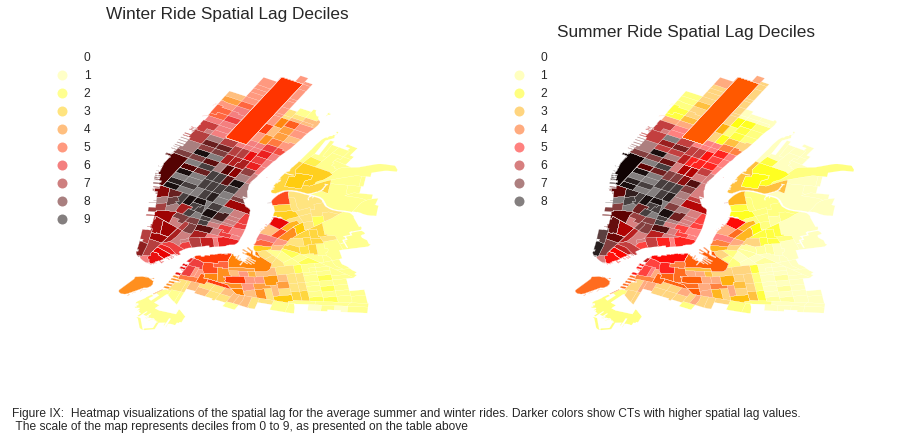

In [97]:
# Create a color map using the deciles obtained on the previous sets

print ('Montly Ride Lag Deciles for Winter \n')
print (MonthlyRideLagQ10Winter)
print ('\n \n')

print ('Montly Ride Lag Deciles for Summer')
print (MonthlyRideLagQ10Summer)

f, (ax1, ax2) = pl.subplots(ncols=2, figsize=(15, 6))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10Winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()

ax1.set_title("Winter Ride Spatial Lag Deciles \n")
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10Summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
ax2.set_title("Summer Ride Spatial Lag Deciles")

pl.figtext(0.1,0,"Figure IX:  Heatmap visualizations of the spatial lag for the average summer and winter rides. "
           "Darker colors show CTs with higher spatial lag values. \n The scale of the map represents"
          " deciles from 0 to 9, as presented on the table above")

## Global  Spatial Autocorrelation

In [98]:
# Calculated considering the montly ride lag
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948478, 348.82325173299694)

### Moran Scatterplot

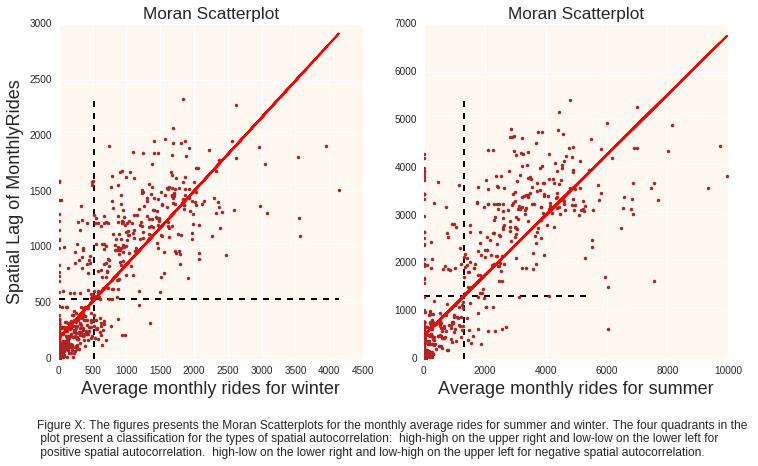

In [106]:
# Meassuring the spatial autocorrelation using Morans I
# https://en.wikipedia.org/wiki/Moran's_I

f, (ax1, ax2) = pl.subplots(ncols=2, figsize=(12, 6))

ax1.plot(MonthlyRideWinter, MonthlyRideLagWinter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax1.vlines(MonthlyRideWinter.mean(), MonthlyRideLagWinter.min(), MonthlyRideLagWinter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(MonthlyRideLagWinter.mean(), MonthlyRideWinter.min(), MonthlyRideWinter.max(), linestyle='--')

# red line of best fit using local I as slope
b,a = np.polyfit(MonthlyRideWinter, MonthlyRideLagWinter, 1)
ax1.plot(MonthlyRideWinter, a + b * MonthlyRideWinter, 'r')
ax1.set_title('Moran Scatterplot')
ax1.set_ylabel('Spatial Lag of MonthlyRides', fontsize=18)
ax1.set_xlabel('Average monthly rides for winter', fontsize=18)

ax2.plot(MonthlyRideSummer, MonthlyRideLagSummer, '.', color='firebrick')

# dashed vert at mean of the last year's PCI
ax2.vlines(MonthlyRideSummer.mean(), MonthlyRideLagSummer.min(),
           MonthlyRideLagSummer.max(), linestyle='--')
# dashed horizontal at mean of lagged PCI
ax2.hlines(MonthlyRideLagSummer.mean(), MonthlyRideLagSummer.min(), MonthlyRideLagSummer.max(), linestyle='--')

# red line of best fit using local I as slope
b,a = np.polyfit(MonthlyRideSummer, MonthlyRideLagSummer, 1)
ax2.plot(MonthlyRideSummer, a + b * MonthlyRideSummer, 'r')
ax2.set_title('Moran Scatterplot')
#plt.ylabel('Spatial Lag of MonthlyRides', fontsize=18)
ax2.set_xlabel('Average monthly rides for summer', fontsize=18)



pl.figtext(0.1,-.1,"Figure X: The figures presents the Moran Scatterplots for the monthly "
           "average rides for summer and winter. The four quadrants in the \n plot present a "
           "classification for the types of spatial autocorrelation:  high-high on the upper "
           "right and low-low on the lower left for \n positive spatial autocorrelation. "
           " high-low on the lower right and low-high on the upper left for negative spatial autocorrelation.")

### Moran's I

In [108]:
# Calculate the Moran's I statistic, which meassures the spatial autocorrelation for our Montly Rides 
# https://en.wikipedia.org/wiki/Moran's_I

I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

I_MonthlyRideSummer = ps.Moran(MonthlyRideSummer, qW_CT)

I_MonthlyRideWinter = ps.Moran(MonthlyRideWinter, qW_CT)


In [110]:
print (I_MonthlyRide.I, I_MonthlyRide.p_sim)
print (I_MonthlyRideSummer.I, I_MonthlyRideSummer.p_sim)
print (I_MonthlyRideWinter.I, I_MonthlyRideWinter.p_sim)

(0.65579332908409083, 0.001)
(0.62946359212848391, 0.001)
(0.65951383017490961, 0.001)


Thus, the $I$ statistic for all three data sets is between $0.656$ and $0.629$ for this data, and has a very small $p$ value. 

In [111]:
I_MonthlyRide.sim[0:10]

array([-0.02279739, -0.02199919,  0.00461477, -0.01480153,  0.01997447,
        0.01737077, -0.01364103, -0.02215118, -0.00166055,  0.02527042])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [118]:
pl.rcParams['figure.figsize']=(14,7)

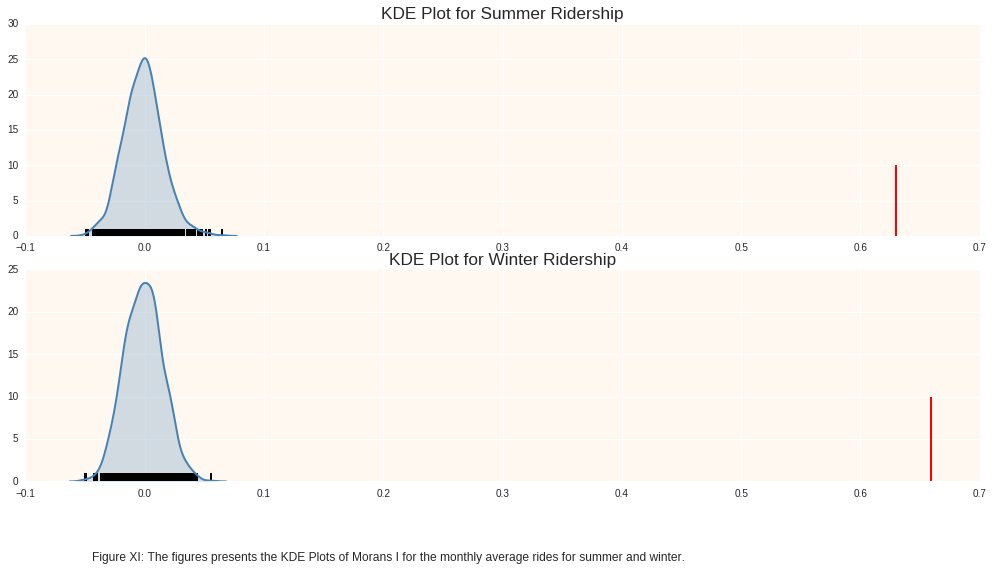

In [121]:
fig, (ax1, ax2) = pl.subplots(nrows=2, ncols=1)
fig.tight_layout()

sns.kdeplot(I_MonthlyRideWinter.sim, shade=True, ax=ax2)
ax2.vlines(I_MonthlyRideWinter.sim, 0, 1)
ax2.vlines(I_MonthlyRideWinter.I, 0, 10, 'r')
ax2.set_title('KDE Plot for Winter Ridership')

sns.kdeplot(I_MonthlyRideSummer.sim, shade=True, ax=ax1)
ax1.vlines(I_MonthlyRideSummer.sim, 0, 1)
ax1.vlines(I_MonthlyRideSummer.I, 0, 10, 'r')
ax1.set_title('KDE Plot for Summer Ridership')


pl.figtext(0.1,-.1,"Figure XI: The figures presents the KDE Plots of Morans I for the monthly "
           "average rides for summer and winter.")

## Local  Spatial Autocorrelation

In [144]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)
LMo_MonthlyRideSummer = ps.Moran_Local(MonthlyRideSummer, qW_CT,permutations=999)
LMo_MonthlyRideWinter = ps.Moran_Local(MonthlyRideWinter, qW_CT,permutations=999)

### LISA (Local Indicators of Spatial Autocorrelation)

In [145]:
sigsSummer = MonthlyRide[LMo_MonthlyRideSummer.p_sim <= .001]
W_sigsSummer = MonthlyRideLag[LMo_MonthlyRideSummer.p_sim <= .001]
insigsSummer = MonthlyRide[LMo_MonthlyRideSummer.p_sim > .001]
W_insigsSummer = MonthlyRideLag[LMo_MonthlyRideSummer.p_sim > .001]


sigsWinter = MonthlyRide[LMo_MonthlyRideWinter.p_sim <= .001]
W_sigsWinter = MonthlyRideLag[LMo_MonthlyRideWinter.p_sim <= .001]
insigsWinter = MonthlyRide[LMo_MonthlyRideWinter.p_sim > .001]
W_insigsWinter = MonthlyRideLag[LMo_MonthlyRideWinter.p_sim > .001]


### Plot Signficant LISA

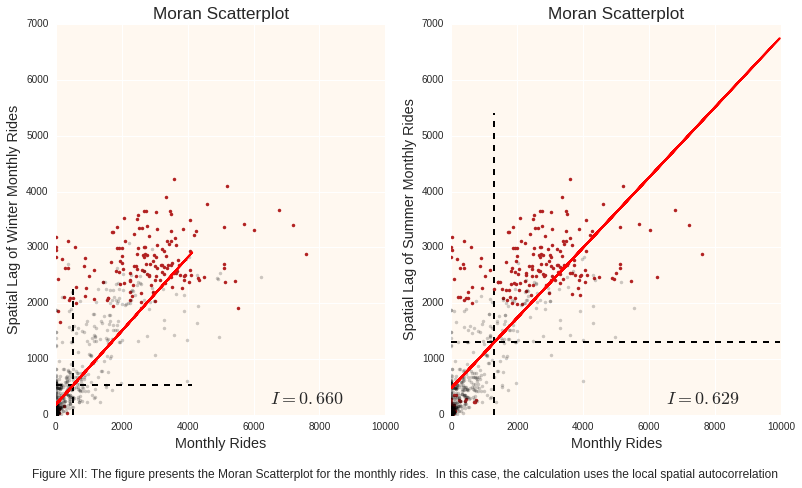

In [151]:
f, (ax1, ax2) = pl.subplots(ncols=2, figsize=(13, 7))

# Winter plot
ax1.plot(sigsWinter, W_sigsWinter, '.', color='firebrick')
ax1.plot(insigsWinter, W_insigsWinter, '.k', alpha=.2)
ax1.text(s='$I = %.3f$' % I_MonthlyRideWinter.I, x=6500, y=200, fontsize=18)

ax1.vlines(MonthlyRideWinter.mean(), MonthlyRideLagWinter.min(),
           MonthlyRideLagWinter.max(), linestyle='--')

ax1.hlines(MonthlyRideLagWinter.mean(), MonthlyRideWinter.min(), 
           MonthlyRideWinter.max(), linestyle='--')

b,a = np.polyfit(MonthlyRideWinter, MonthlyRideLagWinter, 1)
ax1.plot(MonthlyRideWinter, a + b * MonthlyRideWinter, 'r')
ax1.set_title('Moran Scatterplot')
ax1.set_ylabel('Spatial Lag of Winter Monthly Rides')
ax1.set_xlabel('Monthly Rides')
ax1.set_ylim(0, 7000)
ax1.set_xlim(0, 10000)

# Summer plot
ax2.plot(sigsSummer, W_sigsSummer, '.', color='firebrick')
ax2.plot(insigsSummer, W_insigsSummer, '.k', alpha=.2)
ax2.text(s='$I = %.3f$' % I_MonthlyRideSummer.I, x=6500, y=200, fontsize=18)

ax2.vlines(MonthlyRideSummer.mean(), MonthlyRideLagSummer.min(),
           MonthlyRideLagSummer.max(), linestyle='--')

ax2.hlines(MonthlyRideLagSummer.mean(), MonthlyRideSummer.min(), 
           MonthlyRideSummer.max(), linestyle='--')

b,a = np.polyfit(MonthlyRideSummer, MonthlyRideLagSummer, 1)
ax2.plot(MonthlyRideSummer, a + b * MonthlyRideSummer, 'r')
ax2.set_title('Moran Scatterplot')
ax2.set_ylabel('Spatial Lag of Summer Monthly Rides')
ax2.set_xlabel('Monthly Rides')

pl.figtext(0.1,0,"Figure XII: The figure presents the Moran Scatterplot for the monthly rides. "
           " In this case, the calculation uses the local spatial autocorrelation")

### Hot and Cold spots 

In [148]:
# Winter
sigWinter = LMo_MonthlyRideWinter.p_sim < 0.01
hotspotsWinter = LMo_MonthlyRideWinter.q==1 * sigWinter
coldspotsWinter = LMo_MonthlyRideWinter.q==3 * sigWinter

# Summer
sigSummer = LMo_MonthlyRideSummer.p_sim < 0.01
hotspotsSummer = LMo_MonthlyRideSummer.q==1 * sigSummer
coldspotsSummer = LMo_MonthlyRideSummer.q==3 * sigSummer

print "Number of Summer Hotspots:", hotspotsSummer.sum()
print "Number of Summer Coldspots:", coldspotsSummer.sum()
print "Number of Winter Hotspots:", hotspotsWinter.sum()
print "Number of Winter Coldspots:", coldspotsWinter.sum()

Number of Summer Hotspots: 190
Number of Summer Coldspots: 209
Number of Winter Hotspots: 194
Number of Winter Coldspots: 211


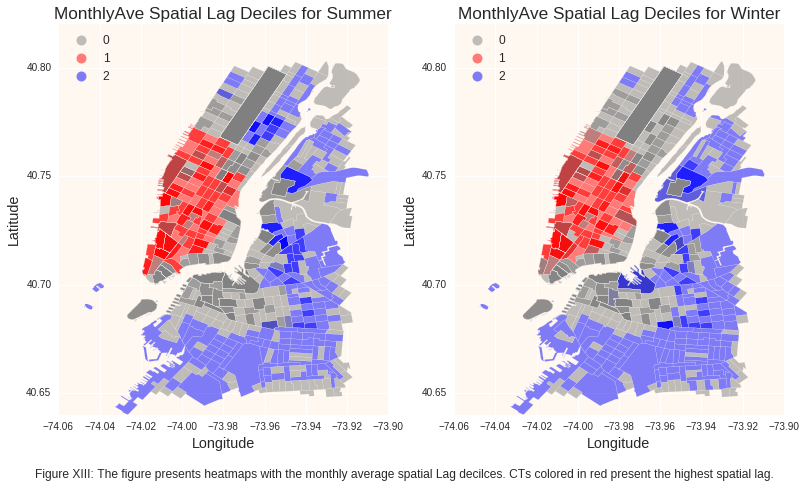

In [153]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcoldSummer = hotspotsSummer * 1 + coldspotsSummer * 2
hotcoldWinter = hotspotsWinter * 1 + coldspotsWinter * 2

fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(13, 7))


# Winter Plot
ct_shape_MonthlyAve_Zoom.assign(cl=hotcoldWinter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_title('MonthlyAve Spatial Lag Deciles for Winter')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Summer Plot
ct_shape_MonthlyAve_Zoom.assign(cl=hotcoldSummer).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_title('MonthlyAve Spatial Lag Deciles for Summer')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')


pl.figtext(0.1,0,"Figure XIII: The figure presents heatmaps with the monthly average"
           " spatial Lag decilces. CTs colored in red present the highest spatial lag.")